# Project Baseline

## Prerequisites for running this notebook
1. Use the docker image vovacher/dl3:cpu to create a container and load this Notebook from inside that docker container.
2. Make sure you install [Kaggle-Cli](https://github.com/floydwch/kaggle-cli)
3. Accept the Contest Rules as shown in the screenshot below:
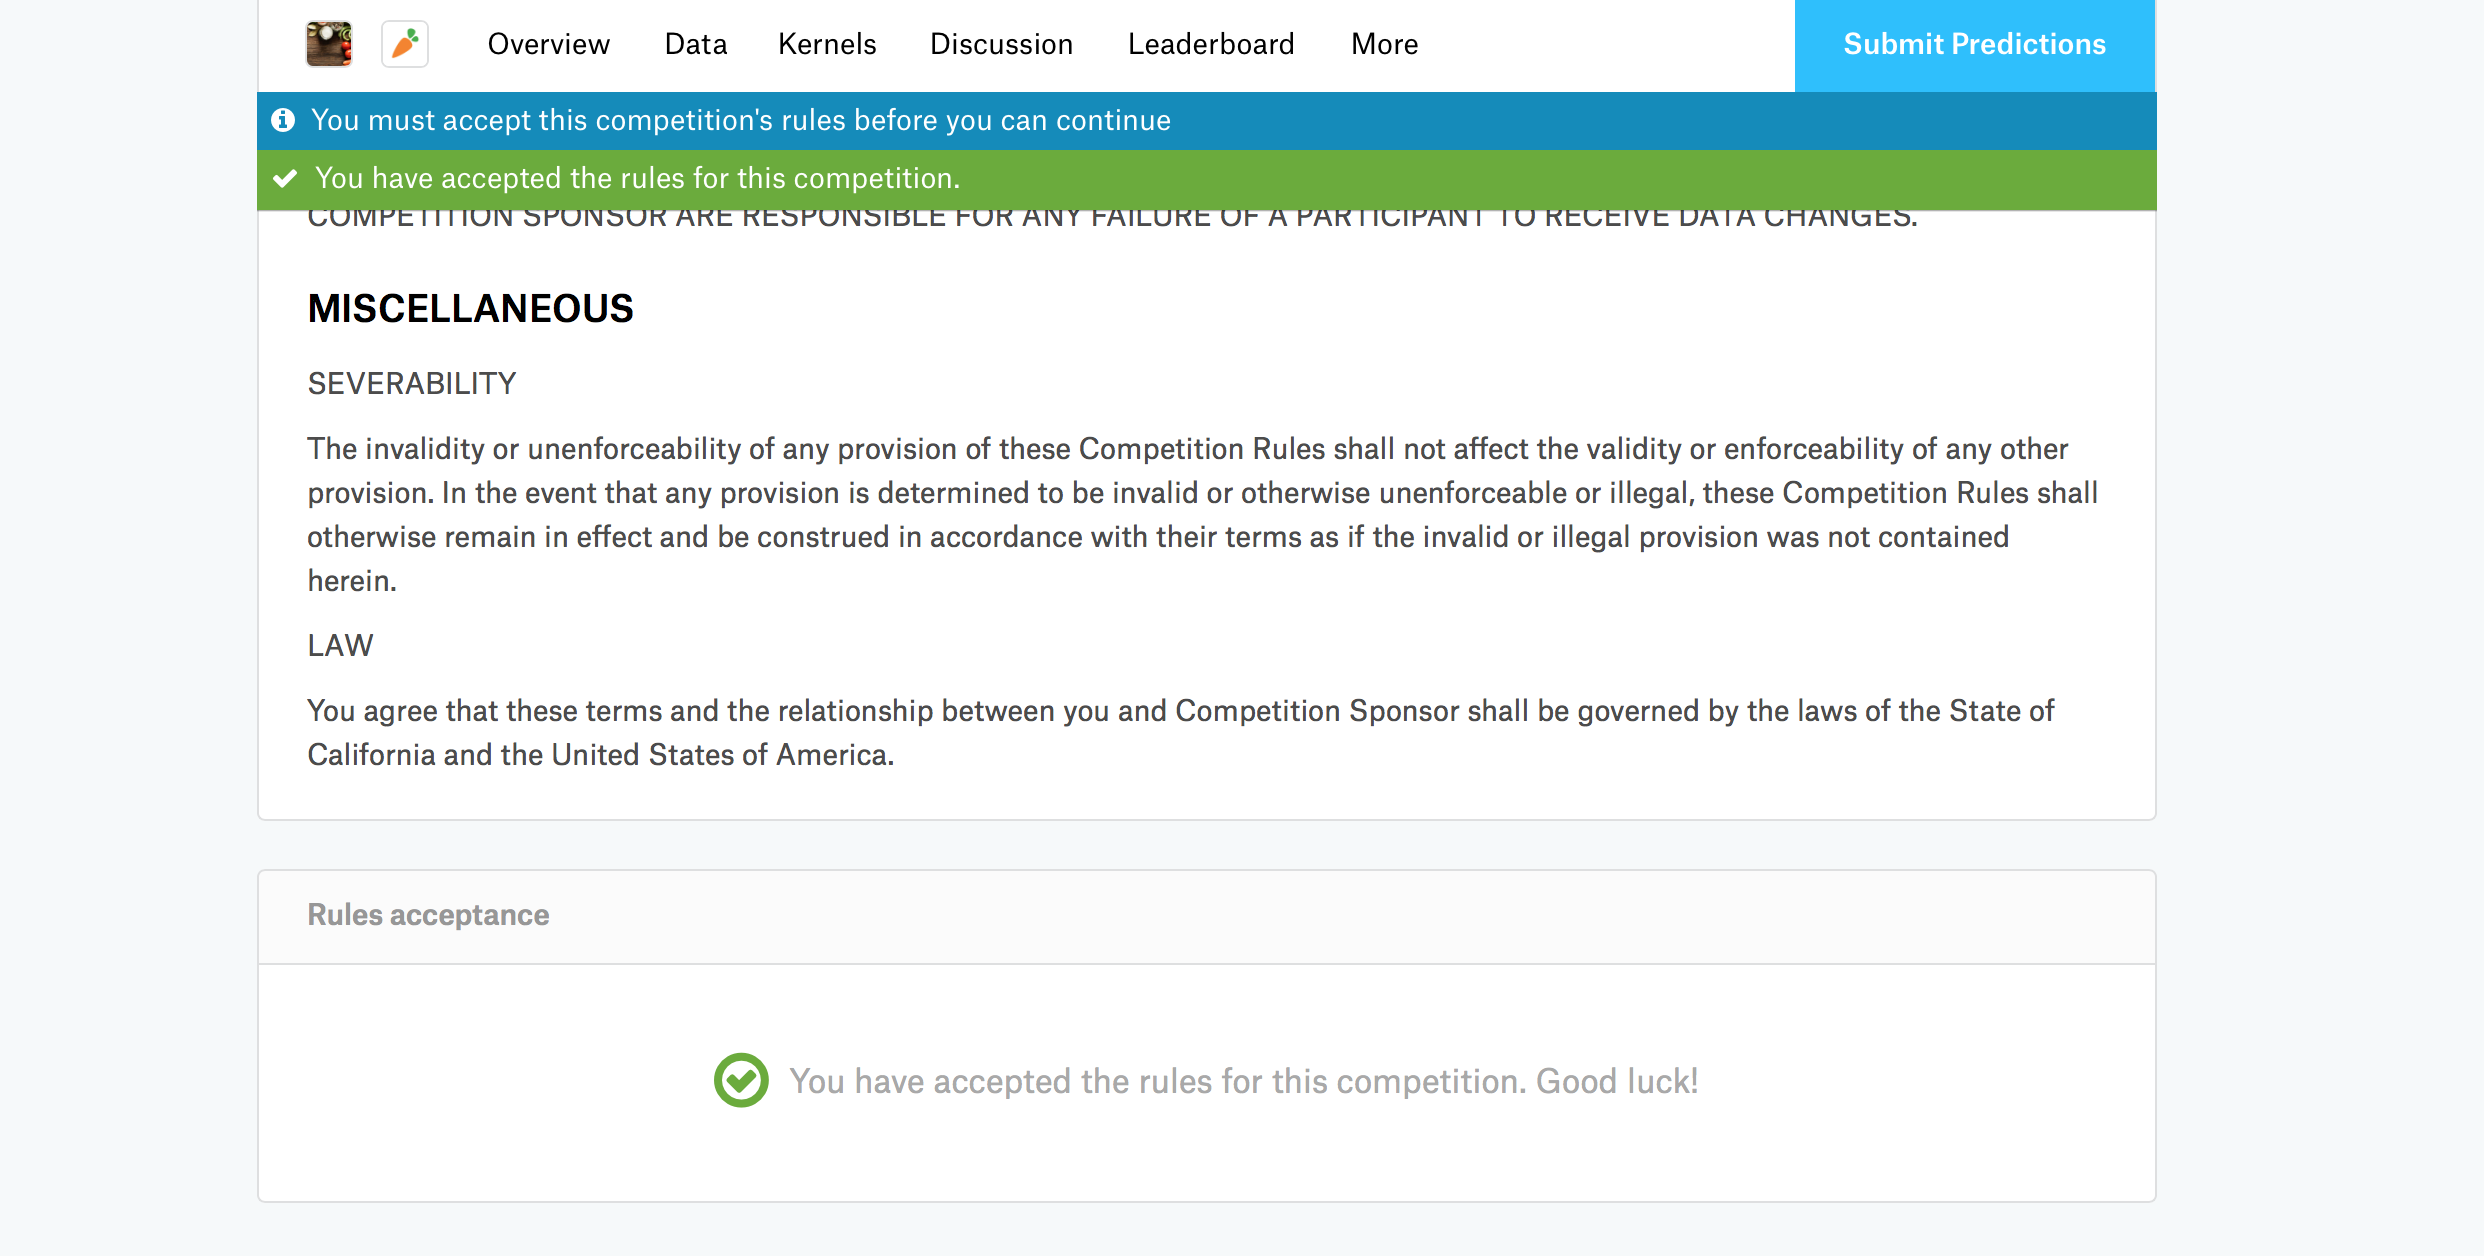


## Initialize your kaggle cli and download data
You would need to connect to Kaggle using the cli command and download all the data under /root/data: 

```
kg download -u username -p password -c instacart-market-basket-analysis

downloading https://www.kaggle.com/c/instacart-market-basket-analysis/download/departments.csv.zip
departments.csv.zip 100% | Time: 0:00:00   1.2 KiB/s

downloading https://www.kaggle.com/c/instacart-market-basket-analysis/download/aisles.csv.zip
aisles.csv.zip 100% | Time: 0:00:01   1.6 KiB/s

downloading https://www.kaggle.com/c/instacart-market-basket-analysis/download/order_products__train.csv.zip
order_products__train.csv.zip 100% | Time: 0:00:11 610.0 KiB/s

downloading https://www.kaggle.com/c/instacart-market-basket-analysis/download/products.csv.zip
products.csv.zip 100% | Time: 0:00:01 580.6 KiB/s

downloading https://www.kaggle.com/c/instacart-market-basket-analysis/download/orders.csv.zip
orders.csv.zip 100% | Time: 0:00:33 954.5 KiB/s

downloading https://www.kaggle.com/c/instacart-market-basket-analysis/download/order_products__prior.csv.zip
order_products__prior.csv.zip 100% | Time: 0:02:46 963.1 KiB/s

downloading https://www.kaggle.com/c/instacart-market-basket-analysis/download/sample_submission.csv.zip
sample_submission.csv.zip 100% | Time: 0:00:01 172.2 KiB/s
```

## Baseline Code

### Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Flatten
from keras.layers import Recurrent, SimpleRNN, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split

import zipfile
import os 

CURRENT_DIR = os.getcwd()

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load data

In [14]:
DATA_DIR = "/root/data/"
DATA_FILES = {'dept':'departments.csv','ail':'aisles.csv','ord_p':'order_products__prior.csv','ord_t':'order_products__train.csv','ord':'orders.csv','prod':'products.csv'}
DATA_FRAMES = {}

if not os.path.exists(DATA_DIR):
    print("Can't find the data directory!")
else:
    for (k,v) in DATA_FILES.items():
        DATA_FRAMES[k]  = pd.read_csv(DATA_DIR+v)
        DATA_FRAMES[k].head(5)


#### Departments

In [16]:
DATA_FRAMES['dept'].head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


#### Aisles

In [17]:
DATA_FRAMES['ail'].head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


#### Order Prior

In [18]:
DATA_FRAMES['ord_p'].head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


#### Order Train

In [19]:
DATA_FRAMES['ord_t'].head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


#### Orders

In [20]:
DATA_FRAMES['ord'].head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


#### Products

In [21]:
DATA_FRAMES['prod'].head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
